# Supervised Learning Flow – Titanic Survival Prediction  

**Student:** Yarin S. (ID: 8635)  

### Introduction
In this assignment I worked on a complete supervised learning flow using the Titanic dataset.  
The goal is to build a model that predicts whether a passenger survived (1) or not (0).  

### Tools and Assistance Used
While preparing this assignment I reviewed some online resources.  
I also used ChatGPT as a study aid – it helped me understand how cross-validation works,  
how to evaluate models with the F1 score, and the importance of comparing algorithms such as Logistic Regression and Random Forest.  


## 1. Data Loading and Initial Exploration

In [8]:

import pandas as pd

# Load train and test data (relative paths for portability)
train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")

# Display first 5 rows
train_df.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [9]:

# Shape and basic information
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nMissing values in train:")
print(train_df.isnull().sum())


Train shape: (712, 8)
Test shape: (179, 8)

Missing values in train:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


## 2. Exploratory Data Analysis (EDA)

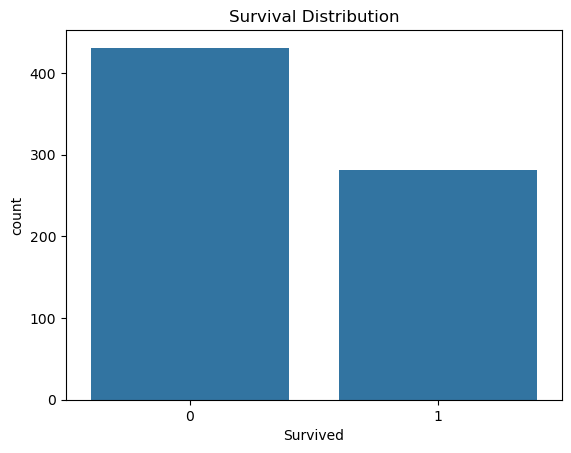

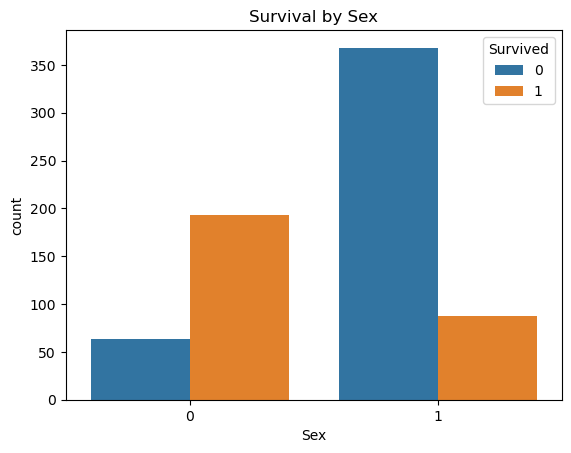

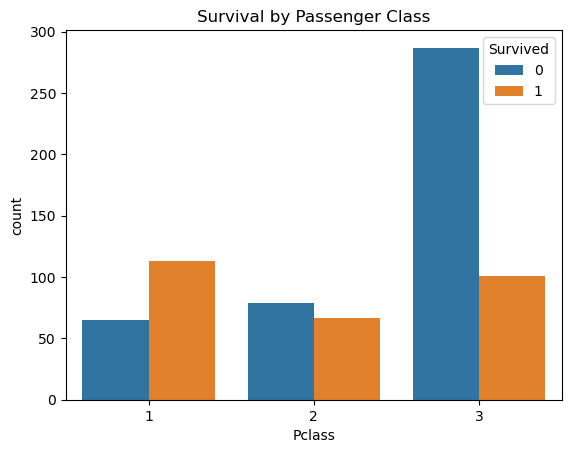

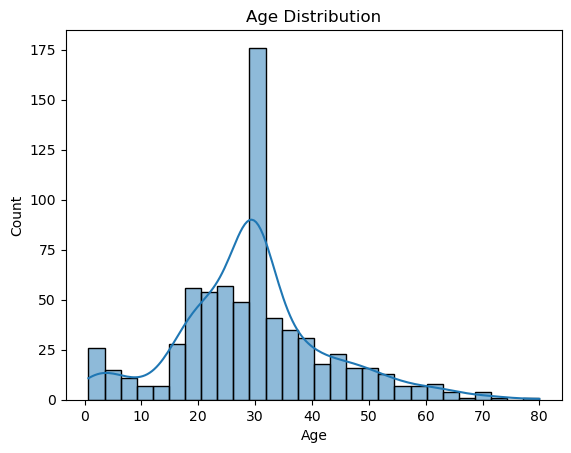

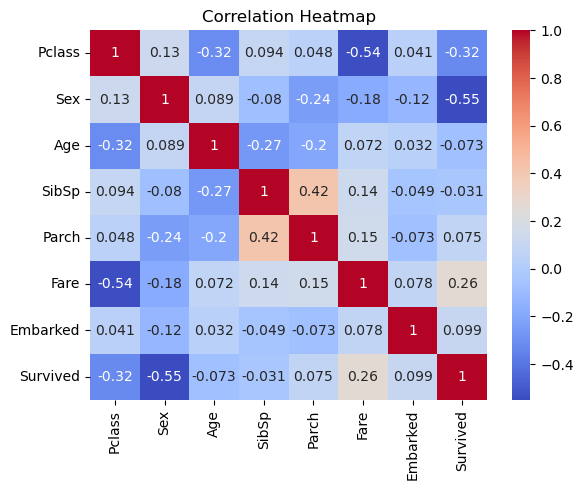

In [10]:

import seaborn as sns
import matplotlib.pyplot as plt

# Survival distribution
sns.countplot(x="Survived", data=train_df)
plt.title("Survival Distribution")
plt.show()

# Sex vs Survival
sns.countplot(x="Sex", hue="Survived", data=train_df)
plt.title("Survival by Sex")
plt.show()

# Pclass vs Survival
sns.countplot(x="Pclass", hue="Survived", data=train_df)
plt.title("Survival by Passenger Class")
plt.show()

# Age distribution
sns.histplot(train_df["Age"].dropna(), kde=True)
plt.title("Age Distribution")
plt.show()

# Correlation heatmap
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## 3. Feature Engineering and Preprocessing

In [11]:

# Select relevant features
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target = "Survived"

# Handle missing values
print("Missing values before:")
print(train_df[features].isnull().sum())

train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].median())
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].median())
test_df["Embarked"] = test_df["Embarked"].fillna(test_df["Embarked"].mode()[0])

print("\nMissing values after:")
print(train_df[features].isnull().sum())

# One-hot encoding
X = pd.get_dummies(train_df[features])
y = train_df[target]
X_test_final = pd.get_dummies(test_df[features])

# Align columns
X, X_test_final = X.align(X_test_final, join="left", axis=1, fill_value=0)

print("\nFeatures after one-hot encoding:")
print(list(X.columns))
print("\nFirst 5 rows of processed data:")
print(X.head())


Missing values before:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Missing values after:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Features after one-hot encoding:
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

First 5 rows of processed data:
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       1    0  54.0      1      0  78.2667         1
1       2    0  45.0      0      0  13.5000         0
2       3    1  20.0      0      0   9.5000         0
3       3    1  36.0      0      0   7.8958         0
4       3    1  22.0      0      0   8.0500         0


## 4. Model Training and Experiments

All experiment results:
                Model                                    Params   Mean F1
0  LogisticRegression         {'C': 0.1, 'solver': 'liblinear'}  0.729365
1  LogisticRegression           {'C': 1, 'solver': 'liblinear'}  0.733387
2  LogisticRegression          {'C': 10, 'solver': 'liblinear'}  0.739009
3        RandomForest     {'max_depth': 3, 'n_estimators': 100}  0.722683
4        RandomForest     {'max_depth': 3, 'n_estimators': 200}  0.715801
5        RandomForest     {'max_depth': 5, 'n_estimators': 100}  0.751221
6        RandomForest     {'max_depth': 5, 'n_estimators': 200}  0.766591
7        RandomForest  {'max_depth': None, 'n_estimators': 100}  0.751522
8        RandomForest  {'max_depth': None, 'n_estimators': 200}  0.744712


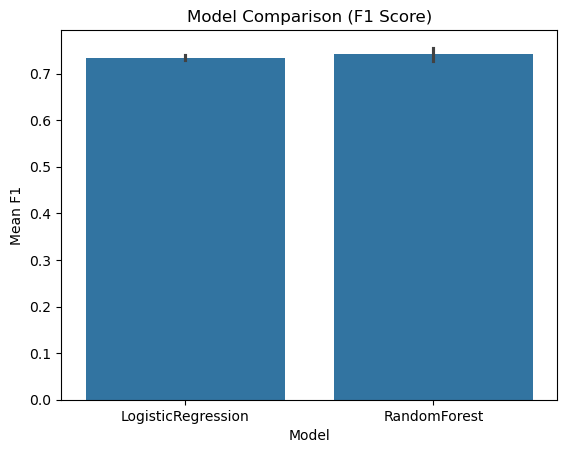


Best configuration:
Model                               RandomForest
Params     {'max_depth': 5, 'n_estimators': 200}
Mean F1                                 0.766591
Name: 6, dtype: object


In [12]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

# Define models and hyperparameters
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, None]
        }
    }
}

# Perform grid search with 5-fold CV
results = []
scorer = make_scorer(f1_score)

for name, mp in models.items():
    clf = GridSearchCV(mp["model"], mp["params"], cv=5, scoring=scorer, n_jobs=-1, return_train_score=True)
    clf.fit(X, y)
    for mean, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['params']):
        results.append({"Model": name, "Params": params, "Mean F1": mean})

results_df = pd.DataFrame(results)
print("All experiment results:")
print(results_df)

# Plot comparison
sns.barplot(x="Model", y="Mean F1", data=results_df)
plt.title("Model Comparison (F1 Score)")
plt.show()

# Find best result
best_row = results_df.sort_values(by="Mean F1", ascending=False).iloc[0]
print("\nBest configuration:")
print(best_row)


## 5. Train Best Model

In [13]:

if best_row["Model"] == "LogisticRegression":
    final_model = LogisticRegression(max_iter=1000, **best_row["Params"])
else:
    final_model = RandomForestClassifier(**best_row["Params"])

# Train on full train set
final_model.fit(X, y)
print("Final model trained with params:", best_row["Params"])


Final model trained with params: {'max_depth': 5, 'n_estimators': 200}


## 6. Evaluation on Test Set

First 10 predictions: [0 0 0 1 0 0 0 0 1 0]


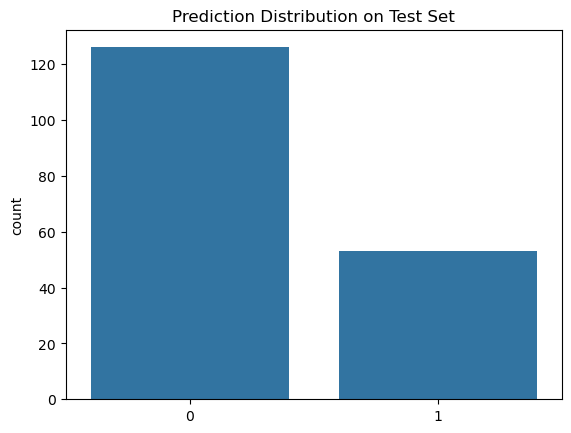

Submission file saved: titanic_predictions.csv


In [14]:

# Predict on test set
test_predictions = final_model.predict(X_test_final)

# Show first predictions
print("First 10 predictions:", test_predictions[:10])

# Prediction distribution
sns.countplot(x=test_predictions)
plt.title("Prediction Distribution on Test Set")
plt.show()

# Handle PassengerId: use if exists, else create index
if "PassengerId" in test_df.columns:
    submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_predictions
    })
else:
    submission = pd.DataFrame({
        "PassengerId": range(1, len(test_predictions) + 1),
        "Survived": test_predictions
    })

submission.to_csv("titanic_predictions.csv", index=False)
print("Submission file saved: titanic_predictions.csv")
